In [2]:
import sys
sys.path.append("../")

In [3]:
import numpy as np
import math as m
import matplotlib.pyplot as plt
import pandas as pd

# Import pyACC logger
from pyACC.helpers import Logger

# Set the logger
print = Logger("pyACC.CosmologicalDistances")

# Import integration class
from pyACC.Cosmology.distances import Dc, Dc_w0wa


In [4]:
# Implement your favourite Hubble function
def hubble_function(z,omega_mat,omega_rad,w,H0):
    return H0*m.sqrt(omega_mat*(1+z)**3 + omega_rad*(1+z)**4 + (1 - omega_mat - omega_rad)*(1+z)**(3*(1+w)))

# Now I compute cosmological distances
z=1
omega_mat = 0.319
omega_rad = 0
w = -1
H0=67
get_distances = Dc(hubble_function,z,omega_mat,omega_rad,w,H0)

# Comoving distance at z=1
print(get_distances, "Mpc")

2024-07-24 09:23:53.979191 :: pyACC.CosmologicalDistances  :: 3418.040545450445 Mpc


In [5]:
# array of redshifts
z_list = np.arange(0, 2, 0.01) + 0.01/2

#array of comoving_distance: com_dist_list
comoving_distance =[]
comoving_distance_w =[]
angular_diameter_distance=[]
luminosity_distance =[]
distance_modulus=[]
n=0
f1 = open("comoving_distances.txt","w")

# Calculate the comoving distance at each redshift in z_list
for z_prime in z_list:
    comoving_distance.append(Dc(hubble_function,z_prime,omega_mat,omega_rad,w,H0))
    f1.write(str(round(z_prime, 3)) + "  ")
    f1.write(str(comoving_distance[n]) + "  ")
    f1.write("\n")
    n=n+1

#print(comoving_distance)
f1.close()

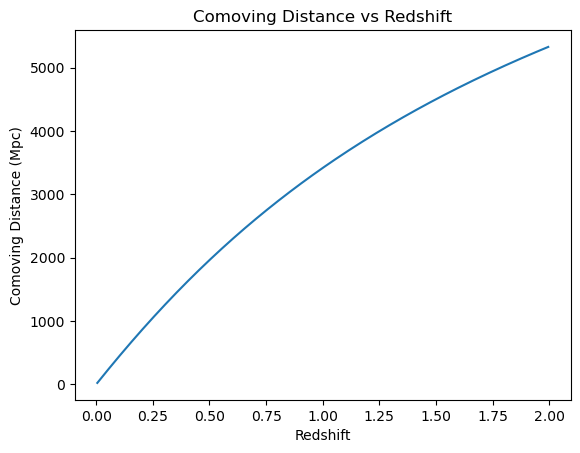

In [6]:
# plot comoving distance vs redshift
plt.plot(z_list,comoving_distance)
plt.xlabel("Redshift")
plt.ylabel("Comoving Distance (Mpc)")
plt.title("Comoving Distance vs Redshift")
plt.show()

In [7]:
import sys
import platform
import os
import pandas as pd
import numpy as np
import emcee
import corner
import matplotlib.pyplot as plt
import camb

def hubble_function_w0wa(z, Omega_m, Omega_r, Omega_k, Omega_lambda, w0, wa, H0):
    # Calculate the dark energy contribution
    dark_energy_contribution = (1 + z)**(3 * (1 + w0 + wa)) * np.exp(-3 * wa * z / (1 + z))
    
    # Calculate H(z)
    Hz = H0 * np.sqrt(
        Omega_m * (1 + z)**3 +
        Omega_r * (1 + z)**4 +
        Omega_k * (1 + z)**2 +
        Omega_lambda * dark_energy_contribution
    )
    
    return Hz

# Now I compute cosmological distances
z=1
omega_mat = 0.319
omega_rad = 0
omega_k = 0
omega_lambda = 0.621
w0 = -1
wa = 0
H0=67
get_distances = Dc_w0wa(hubble_function_w0wa,z,omega_mat,omega_rad,omega_k,omega_lambda,w0,wa,H0) #this is equivalent to get_mu(z, H0, Om0, w0, wa)

# Comoving distance at z=1
print(get_distances, "Mpc")


    

2024-07-24 09:23:55.388546 :: pyACC.CosmologicalDistances  :: 3485.2132470603515 Mpc


2024-07-24 09:24:00.016844 :: pyACC.CosmologicalDistances  :: 1022


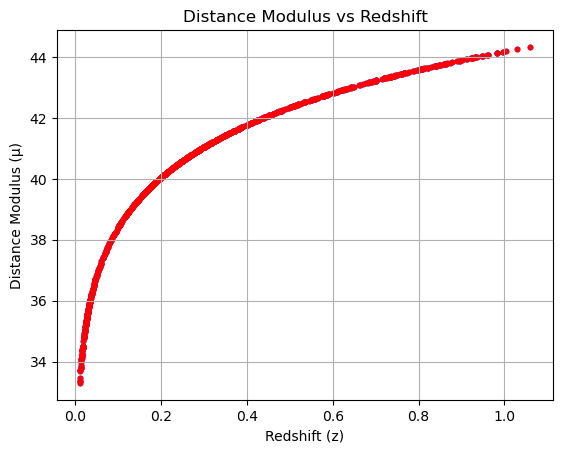

In [8]:
# Generation of the data (to verify the code I generate the synthetic data)
# I take the redshift by the file, so I must read the file

# Load the data
file_path = 'lcparam_full_long.txt'

# Read the first line to get the header
with open(file_path, 'r') as file:
    header_line = file.readline().strip()
    header = header_line.lstrip('#').strip()

# Remove the last word from the header (assumed to be 'biascor')
header_words = header.split()
header_words.pop()
header = ' '.join(header_words)

# Read the rest of the file into a DataFrame
data = pd.read_csv(file_path, sep='\s+', skiprows=1, header=None)
data.columns = header.split()

#The list of redshift is:
z = data['zcmb'].values
mu = []
mu_new = []
comoving_distance = []
luminosity_distance = []


for z_prime in z:
    comoving_distance.append(Dc(hubble_function,z_prime,omega_mat,omega_rad,w,H0))

for i in range(0,len(z),1):
    luminosity_distance.append(comoving_distance[i]*(1+z[i]))
    mu.append( 5*np.log10(luminosity_distance[i]) +25 )

for z_prime in z:
    mu_new.append(5*np.log10(Dc(hubble_function,z_prime,omega_mat,omega_rad,w0,H0)*(1+z_prime)) + 25)

print(len(mu))

# Create scatter plot
plt.scatter(z, mu, color='blue', s=10)
plt.scatter (z, mu_new, color='red', s=10)
plt.xlabel('Redshift (z)')
plt.ylabel('Distance Modulus (μ)')
plt.title('Distance Modulus vs Redshift')
plt.grid(True)
plt.show()

# So far, I only "generate" z ("generate" because really we read them by the file)
# Now I make the generation of the data ???

In [9]:
# Now I create the likelihood, the prior and the posterior

def ln_likelihood(params, data, cov_inv):
    H0, Om0 = params #, w0, wa
    z = data['zcmb'].values
    d = data['mb'].values
    try:
        mu =  5*np.log10(Dc(hubble_function,z_prime,Om0,0,-1,H0)*(1+z)) + 25 #it is equivalent to get_mu(z, H0, Om0, w0, wa)
    except Exception as e:
        print(f"Error in get_mu: {e}")
        return -np.inf
    diff = d - mu
    term1 = -0.5 * diff @ cov_inv @ diff # @ is the matrix multiplication
    term2 = 0 #0.5 * ((np.ones_like(diff) @ cov_inv @ diff) ** 2) / (np.ones_like(diff) @ cov_inv @ np.ones_like(diff))
    return term1 + term2

def log_prior(params):
    H0, Om0 = params #, w0, wa
    if not (60 < H0 < 80):
        return -np.inf
    if not (0.2 < Om0 < 0.4):
        return -np.inf
    '''
    if not (-1.2 < w0 < -0.9):
        return -np.inf
    
    if not (-0.1 < wa < 0.1):
        return -np.inf
    '''
    # Constraint to avoid crossing w = -1 (relaxed)
    '''
    if w0 + wa < -1:
        return -np.inf
    '''
    return 0.0

def log_posterior(params, data, cov_inv):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + ln_likelihood(params, data, cov_inv)




In [10]:
'''
import numpy as np
import pandas as pd
import camb

# Define synthetic data
data = pd.DataFrame({
    'zcmb': np.linspace(0.01, 1, 100),
    'mb': np.linspace(10, 20, 100)
})

# Define synthetic parameters
params = [68.5, 0.32]

# Define synthetic covariance matrix
cov = np.identity(100)
cov_inv = np.linalg.inv(cov)


# Example functions (must be replaced with actual implementations)
def Dc(hubble_function, z, Om0, w0, wa, H0):
    return np.ones_like(z) * 1000  # Placeholder

def hubble_function(z, Om0, w0, wa, H0):
    return H0 * np.sqrt(Om0 * (1 + z)**3 + (1 - Om0))


# Calculate likelihood
ln_likelihood(params, data, cov_inv)

import matplotlib.pyplot as plt
def get_mu(z, H0, Om0, w0, wa):
    pars = camb.CAMBparams()
    pars.set_dark_energy(w=w0, wa=wa)
    pars.set_cosmology(H0=H0, ombh2=0.022, omch2=Om0*0.12)
    pars.InitPower.set_params(ns=0.965)
    results = camb.get_results(pars)
    # Get luminosity distance in Mpc
    dl = results.comoving_radial_distance(z) * (1 + z)
    
    # Convert to distance modulus
    mu = 5 * np.log10(dl) + 25 #The constant 25 is added to adjust the units and to match the conventional definitions used in astronomy -->
    #--> for a luminosity distance of 10 Mpc, the distance modulus would be 30.
    return mu
    
H0, Om0 = params
mu_synthetic = []
z = data['zcmb'].values
d = data['mb'].values
for z_prime in z:
    mu_synthetic.append(5*np.log10(Dc(hubble_function,z_prime,omega_mat,omega_rad,w0,H0)*(1+z_prime)) + 25)

mu_new = get_mu(z, H0, Om0, -1, 0)
plt.figure(figsize=(10, 6))            
plt.plot(z, d, 'o', label='Observed Data')
plt.plot(z, mu_synthetic, '-', label='Model Prediction')
plt.plot(z, mu_new, '--', label='Model Prediction (CAMB)')
plt.xlabel('Redshift (z)')
plt.ylabel('Distance Modulus (mb)')
plt.legend()
plt.show()
#NON CREDO ABBIA SENSO QUESTO GRAFICO
'''


"\nimport numpy as np\nimport pandas as pd\nimport camb\n\n# Define synthetic data\ndata = pd.DataFrame({\n    'zcmb': np.linspace(0.01, 1, 100),\n    'mb': np.linspace(10, 20, 100)\n})\n\n# Define synthetic parameters\nparams = [68.5, 0.32]\n\n# Define synthetic covariance matrix\ncov = np.identity(100)\ncov_inv = np.linalg.inv(cov)\n\n\n# Example functions (must be replaced with actual implementations)\ndef Dc(hubble_function, z, Om0, w0, wa, H0):\n    return np.ones_like(z) * 1000  # Placeholder\n\ndef hubble_function(z, Om0, w0, wa, H0):\n    return H0 * np.sqrt(Om0 * (1 + z)**3 + (1 - Om0))\n\n\n# Calculate likelihood\nln_likelihood(params, data, cov_inv)\n\nimport matplotlib.pyplot as plt\ndef get_mu(z, H0, Om0, w0, wa):\n    pars = camb.CAMBparams()\n    pars.set_dark_energy(w=w0, wa=wa)\n    pars.set_cosmology(H0=H0, ombh2=0.022, omch2=Om0*0.12)\n    pars.InitPower.set_params(ns=0.965)\n    results = camb.get_results(pars)\n    # Get luminosity distance in Mpc\n    dl = results

In [23]:
import numpy as np
from scipy.optimize import minimize

# Load the data
file_path = 'binned_data.txt'

# Read the first line to get the header
with open(file_path, 'r') as file:
    header_line = file.readline().strip()
    header = header_line.lstrip('#').strip()

# Remove the last word from the header (assumed to be 'biascor')
header_words = header.split()
header_words.pop()
header = ' '.join(header_words)

# Read the rest of the file into a DataFrame
data = pd.read_csv(file_path, sep='\s+', skiprows=1, header=None)
data.columns = header.split()

# Extract relevant columns
d = data['mb'].values
dmb = data['dmb'].values
z_lista = data['zcmb'].values
for z_prime in z_lista:
    mu.append(5*np.log10(Dc(hubble_function,z_prime,0.319,0,-1,67)*(1+z_prime)) + 25)
print(len(mu))

'''
def ln_likelihood(params, data, cov_inv):
    H0, Om0 = params #, w0, wa
    z = data['zcmb'].values
    d = data['mb'].values
    try:
        for z_prime in z:
            mu.append(5*np.log10(Dc(hubble_function,z_prime,Om0,0,-1,H0)*(1+z_prime)) + 25) #it is equivalent to get_mu(z, H0, Om0, w0, wa)
    except Exception as e:
        print(f"Error in get_mu: {e}")
        return -np.inf
    diff = d - mu
    term1 = -0.5 * diff @ cov_inv @ diff # @ is the matrix multiplication
    print(len(mu))
    print(len(z))
    
    return term1 

def neg_ln_likelihood(params, data, cov_inv):
    return -2*ln_likelihood(params, data, cov_inv)


from scipy.optimize import minimize

# Example data and covariance inverse matrix
z = data['zcmb'].values
d = data['mb'].values
dmb = data['dmb'].values

# Compute the covariance matrix
Sigma = np.diag(dmb**2)
cov_inv = np.linalg.inv(Sigma)

# Initial guess for the parameters [H0, Om0]
initial_guess = [70, 0.3]
ln_likelihood([70, 0.3], data, np.linalg.inv(np.diag(dmb**2)))
'''
'''
# Run the optimizer
result = minimize(neg_ln_likelihood, initial_guess, args=(data, cov_inv))

# Best fit parameters
best_fit_params = result.x
print(f"Best fit parameters: H0 = {best_fit_params[0]}, Om0 = {best_fit_params[1]}")


# Generate model predictions using the best fit parameters
#z = data['zcmb'].values
H0_best, Om0_best = best_fit_params
mu_best = 5 * np.log10(Dc(hubble_function, z, Om0_best, 0, -1, H0_best) * (1 + z)) + 25

# Plot the observed data and model predictions
plt.errorbar(z, data['mb'], yerr=data['dmb'], fmt='o', label='Observed Data')
plt.plot(z, mu_best, 'r-', label='Best Fit Model')
plt.xlabel('Redshift (z)')
plt.ylabel('Distance Modulus (mu)')
plt.legend()
plt.show()
'''

2024-07-24 09:48:21.712485 :: pyACC.CosmologicalDistances  :: 1222


'\n# Run the optimizer\nresult = minimize(neg_ln_likelihood, initial_guess, args=(data, cov_inv))\n\n# Best fit parameters\nbest_fit_params = result.x\nprint(f"Best fit parameters: H0 = {best_fit_params[0]}, Om0 = {best_fit_params[1]}")\n\n\n# Generate model predictions using the best fit parameters\n#z = data[\'zcmb\'].values\nH0_best, Om0_best = best_fit_params\nmu_best = 5 * np.log10(Dc(hubble_function, z, Om0_best, 0, -1, H0_best) * (1 + z)) + 25\n\n# Plot the observed data and model predictions\nplt.errorbar(z, data[\'mb\'], yerr=data[\'dmb\'], fmt=\'o\', label=\'Observed Data\')\nplt.plot(z, mu_best, \'r-\', label=\'Best Fit Model\')\nplt.xlabel(\'Redshift (z)\')\nplt.ylabel(\'Distance Modulus (mu)\')\nplt.legend()\nplt.show()\n'